# Pangeo Demo: Create a Time Series using HadISST Zarr Store

-------------------

## Import python packages

It is nice to turn off warnings and set xarray display options.  

In [1]:
import warnings
import fsspec
import xarray as xr
import fsspec
warnings.simplefilter('ignore') # filter some warning messages
xr.set_options(display_style="html") # display dataset nicely 

In [65]:
ds = xr.open_zarr('https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/HadISST-feedstock/hadisst.zarr', consolidated=True)
ds

<xarray.Dataset>
Dimensions:    (latitude: 180, longitude: 360, time: 1829, nv: 2)
Coordinates:
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time       (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2022-0...
Dimensions without coordinates: nv
Data variables:
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(1829, 180, 360), meta=np.ndarray>
    time_bnds  (time, nv) float32 dask.array<chunksize=(1829, 2), meta=np.ndarray>
Attributes:
    Conventions:                CF-1.0
    Title:                      Monthly version of HadISST sea surface temper...
    comment:                    Data restrictions: for academic research use ...
    description:                HadISST 1.1 monthly average sea surface tempe...
    history:                    22/7/2022 converted to netcdf from pp format
    institution:                Met Office Hadley Centre
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    source:                     HadISST
    supplementary_information:  Updates and supplementary information will be...

# Define some parameters for slicing the data

In [80]:
import pandas as pd
import numpy as np

dates = xr.date_range(start=np.min(ds.time).values, periods=5, freq='1Y')
dates

DatetimeIndex(['1870-12-31 11:59:59.505615234',
               '1871-12-31 11:59:59.505615234',
               '1872-12-31 11:59:59.505615234',
               '1873-12-31 11:59:59.505615234',
               '1874-12-31 11:59:59.505615234'],
              dtype='datetime64[ns]', freq='A-DEC')

In [82]:
groups = ds.groupby("time.month")

In [142]:
januaries = groups[1]

In [143]:
slice_params = {
    'latitude': 45.5,
    'longitude': -145.5,
    'time': januaries.time
}

In [144]:
sst['sst'].sel(**slice_params)

<xarray.DataArray 'sst' (time: 153)>
dask.array<getitem, shape=(153,), dtype=float32, chunksize=(153,), chunktype=numpy.ndarray>
Coordinates:
    latitude   float32 45.5
    longitude  float32 -145.5
  * time       (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2022-0...
Attributes:
    cell_methods:   time: lat: lon: mean
    long_name:      sst
    standard_name:  sea_surface_temperature
    units:          C

We can use xarray to open the dataset, which uses lazy loading to load the metadata without loading the whole dataset

CPU times: user 851 ms, sys: 421 ms, total: 1.27 s
Wall time: 6.97 s


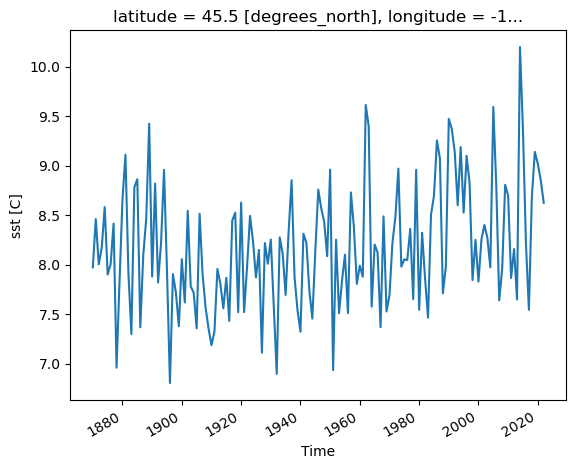

In [145]:
%%time
sst_timeseries = sst['sst'].sel(**slice_params).load()
sst_timeseries.plot()

In [179]:
# calculate the difference from the average for every point on the globe
# what is the average for each point?
avgs = januaries['sst'].mean("time")

last_year = januaries.sel({'time': januaries.time[-1]})

diffs = (last_year['sst'] - avgs)

diffs.plot()

In [221]:
import os
import sys
# sys.path.append(os.path.join(os.environ['HOME'], 'shared', 'users', 'lib'))
import ebdpy as ebd

profile = 'esip-qhub'
region = 'us-west-2'
endpoint = f's3.{region}.amazonaws.com'
ebd.set_credentials(profile=profile, region=region, endpoint=endpoint)
worker_max = 12


client,cluster = ebd.start_dask_cluster(profile=profile,
                                        worker_max=worker_max, 
                                        region=region,
                                        use_existing_cluster=False,
                                        adaptive_scaling=False,
                                        wait_for_cluster=True, 
                                        worker_profile='Pangeo Worker', 
                                        propagate_env=True)

Region: us-west-2
Existing Dask clusters:
Cluster Index c_idx: 0 / Name: dev.962ad028b393432c823ac34d665b7843 ClusterStatus.RUNNING
Starting new cluster.
{}
Setting Cluster Environment Variable AWS_DEFAULT_REGION us-west-2
Setting Fixed Scaling workers=12
Reconnect client to clear cache
client.dashboard_link (for new browser tab/window or dashboard searchbar in Jupyterhub):
https://jupyter.qhub.esipfed.org/gateway/clusters/dev.ea65c93185224620b0c0d50a6940d3f7/status
Elapsed time to wait for 12 live workers:
12/12 workers - 118 seconds
Propagating environment variables to workers
Using environment: users/pangeo


In [222]:
def calc_diff(month):
    month_data = groups[month]
    avgs = month_data['sst'].mean("time")
    last_year = month_data.sel({'time': month_data.time[-1]})
    diffs = (last_year['sst'] - avgs).compute()
    return diffs

In [223]:
futures = client.map(calc_diff, range(1, 12))

In [224]:
results = client.gather(futures)

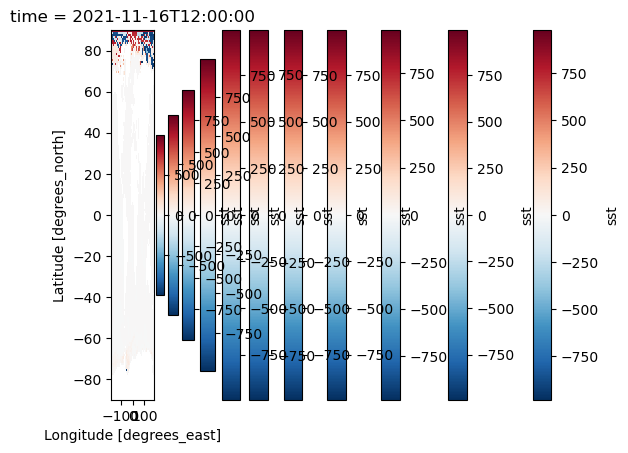

In [225]:
# find a way to plot each result, right now looks crazy if you plot all of them
# [result.plot() for result in results]